In [106]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [107]:
import numpy as np
import pandas as pd
import os

In [108]:
import matplotlib.pyplot as plt

In [109]:
import seaborn as sns

In [110]:
spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
    .config("spark.yarn.access.hadoopFileSystems",os.environ["STORAGE"])\
    .getOrCreate()

#.config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\

In [111]:
#df = spark.read.csv('data/LoanStats_2015_subset.csv')
#df = spark.read.option('inferschema','true').csv('data/original/LoanStats_2015_subset.csv', header=True)

In [113]:
df = spark.read.option('inferschema','true').csv(
  os.environ["STORAGE"] + "/credit_demo/LoanStats_2015_subset_120321.csv",
  header=True,
  sep=',',
  nullValue='NA'
)

In [ ]:
df.take(2)

In [ ]:
print(os.environ["STORAGE"] + "data/LoanStats_2015_subset_120321.csv")

In [10]:
type(df)

pyspark.sql.dataframe.DataFrame

In [11]:
#df.head()

In [15]:
df.printSchema()

root
 |-- acc_now_delinq: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- all_util: integer (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- annual_inc_joint: double (nullable = true)
 |-- application_type: string (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- bc_open_to_buy: integer (nullable = true)
 |-- bc_util: double (nullable = true)
 |-- chargeoff_within_12_mths: integer (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- delinq_amnt: integer (nullable = true)
 |-- desc: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- dti_joint: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- gr

In [16]:
#Printing number of rows and columns:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(145332, 105)


#### Basic Inspection

In [17]:
#Count number of nulls for each column:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,0,0,0,123960,0,144821,0,0,1363,1444,...,145332,145332,145332,145332,145332,145332,145332,145332,145332,145332


In [18]:
#It seems like some columns have a lot of nulls while others have very few:
nulls = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [19]:
null_cols = nulls.T[(nulls.T > 1000).any(axis=1)].index

In [20]:
df = df.drop(*null_cols)

In [21]:
#Printing number of rows:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(145332, 62)


In [22]:
df = df.filter(df.loan_status != '10500')

In [23]:
df.dtypes

[('acc_now_delinq', 'int'),
 ('acc_open_past_24mths', 'int'),
 ('addr_state', 'string'),
 ('annual_inc', 'double'),
 ('application_type', 'string'),
 ('avg_cur_bal', 'int'),
 ('chargeoff_within_12_mths', 'int'),
 ('collections_12_mths_ex_med', 'int'),
 ('delinq_2yrs', 'int'),
 ('delinq_amnt', 'int'),
 ('dti', 'double'),
 ('earliest_cr_line', 'string'),
 ('emp_length', 'string'),
 ('funded_amnt', 'string'),
 ('funded_amnt_inv', 'double'),
 ('grade', 'string'),
 ('home_ownership', 'string'),
 ('initial_list_status', 'string'),
 ('inq_last_6mths', 'int'),
 ('installment', 'double'),
 ('int_rate', 'string'),
 ('issue_d', 'string'),
 ('loan_amnt', 'string'),
 ('loan_status', 'string'),
 ('mo_sin_old_rev_tl_op', 'int'),
 ('mo_sin_rcnt_rev_tl_op', 'int'),
 ('mo_sin_rcnt_tl', 'int'),
 ('mort_acc', 'int'),
 ('num_accts_ever_120_pd', 'int'),
 ('num_actv_bc_tl', 'int'),
 ('num_actv_rev_tl', 'int'),
 ('num_bc_sats', 'int'),
 ('num_bc_tl', 'int'),
 ('num_il_tl', 'int'),
 ('num_op_rev_tl', 'int'),
 

## KPI Reporting

### What is the target variable and what does it define?

In [24]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
+------------------+



In [25]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|55312|
|           Default|    4|
|   In Grace Period| 1116|
|       Charged Off|19719|
|Late (31-120 days)| 2080|
|           Current|66675|
| Late (16-30 days)|  425|
+------------------+-----+

None


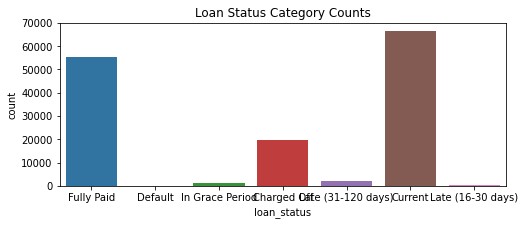

In [26]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(8,3))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

#### To predict defaults, we need to transform the target variable into a binary variable

In [27]:
from pyspark.sql.functions import when

In [28]:
df = df.withColumn("is_default", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

In [29]:
#Checking that we have correctly replaced values
df.select("is_default").show()

+----------+
|is_default|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
|         1|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
+----------+
only showing top 20 rows



In [30]:
df.select("is_default").dtypes

[('is_default', 'int')]

In [31]:
from pyspark.sql import functions as F

In [32]:
#Check the exact total of all loans labeled to default matches with the sum of the original two values used above (Charged Off and Default)
df.select(F.sum("is_default")).collect()[0][0]

19723

### What is the monthly total loan volume in dollars and what is the monthly average loan size?

In [33]:
from pyspark.sql.functions import to_date

In [34]:
#The original issue date attribute
df.select("issue_d").show(4)

+--------+
| issue_d|
+--------+
|Dec-2015|
|Dec-2015|
|Dec-2015|
|Dec-2015|
+--------+
only showing top 4 rows



In [35]:
#We need to cast the issue date from string to month (all loan applications in the dataset occurred in 2015 so we don't need the year):
df.selectExpr("from_unixtime(unix_timestamp(issue_d,'MMM-yyyy'),'MM') as issue_month").show(4)

+-----------+
|issue_month|
+-----------+
|         12|
|         12|
|         12|
|         12|
+-----------+
only showing top 4 rows



In [36]:
df = df.withColumn("issue_month",F.from_unixtime(F.unix_timestamp(F.col("issue_d"),'MMM-yyyy'),'MM'))

In [37]:
df.select("issue_month").distinct().show()

+-----------+
|issue_month|
+-----------+
|         11|
|         09|
|         10|
|         12|
+-----------+



In [38]:
#how many loans defaulted for each month (all data is 2015):
df.groupby('issue_month').sum('is_default').na.drop().sort(F.asc('issue_month')).show()

+-----------+---------------+
|issue_month|sum(is_default)|
+-----------+---------------+
|         09|           2088|
|         10|           6446|
|         11|           5015|
|         12|           6174|
+-----------+---------------+



In [39]:
defaults_date = df.groupby('issue_month').sum('is_default').na.drop().sort(F.asc('issue_month')).toPandas()

In [40]:
defaults_date

,issue_month,sum(is_default)
0,09,2088
1,10,6446
2,11,5015
3,12,6174


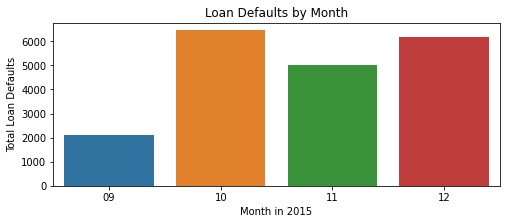

In [41]:
plt.figure(figsize=(8,3))
g = sns.barplot(x="issue_month", y="sum(is_default)", data=defaults_date)
g.set_title('Loan Defaults by Month')
g.set_ylabel('Total Loan Defaults')
g.set_xlabel('Month in 2015')
plt.show()

In [42]:
#Let's create more plots here. First we aggregate in different ways. Then we join, convert to Pandas df, and plot. 

In [43]:
from pyspark.sql.functions import sum as _sum

In [44]:
#by using like function
df.groupBy("issue_month","loan_status").\
count().\
filter(F.lower(F.col("loan_status")).like("late%")).\
groupby('issue_month').\
sum().\
sort(F.asc('issue_month')).\
show()

+-----------+----------+
|issue_month|sum(count)|
+-----------+----------+
|         09|       232|
|         10|       759|
|         11|       643|
|         12|       871|
+-----------+----------+



In [45]:
df_late = df.groupBy("issue_month","loan_status").\
count().\
filter(F.lower(F.col("loan_status")).like("late%")).\
groupby('issue_month').\
sum().\
sort(F.asc('issue_month'))

In [46]:
#by using like function
df_delinq = df.groupBy("issue_month").\
max("inq_last_6mths").\
na.drop().\
sort(F.asc('issue_month'))

In [47]:
#This time we need to cast the attribute we are working with to numeric before we can create a similar dataframe:
df = df.withColumn('loan_amnt', F.col('loan_amnt').cast('int'))

In [48]:
#by using like function
df_ann_inc = df.groupBy("issue_month").\
mean("loan_amnt").\
na.drop().\
sort(F.asc('issue_month'))

In [49]:
df_delinq.alias('a').join(df_ann_inc.alias('b'),F.col('b.issue_month') == F.col('a.issue_month')).\
join(df_late.alias('c'), F.col('b.issue_month') == F.col('c.issue_month')).\
select(F.col('a.issue_month'), F.col('a.max(inq_last_6mths)'), F.col('b.avg(loan_amnt)'), F.col('c.sum(count)').alias('default_count')).\
show()

+-----------+-------------------+------------------+-------------+
|issue_month|max(inq_last_6mths)|    avg(loan_amnt)|default_count|
+-----------+-------------------+------------------+-------------+
|         11|                  5|15114.503730349054|          643|
|         09|                  5|15707.964408262127|          232|
|         10|                  5|15178.663957197243|          759|
|         12|                  5|15062.367228198364|          871|
+-----------+-------------------+------------------+-------------+



In [50]:
df_stats_pd = df_delinq.alias('a').join(df_ann_inc.alias('b'),F.col('b.issue_month') == F.col('a.issue_month')).\
join(df_late.alias('c'), F.col('b.issue_month') == F.col('c.issue_month')).\
select(F.col('a.issue_month'), F.col('a.max(inq_last_6mths)'), F.col('b.avg(loan_amnt)'), F.col('c.sum(count)').alias('default_count')).\
toPandas()

In [51]:
df_stats_pd.head()

,issue_month,max(inq_last_6mths),avg(loan_amnt),default_count
0,11,5,15114.503730,643
1,09,5,15707.964408,232
2,10,5,15178.663957,759
3,12,5,15062.367228,871


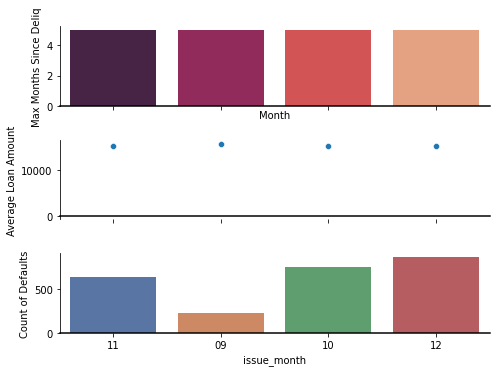

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=df_stats_pd['issue_month'], y=df_stats_pd['max(inq_last_6mths)'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Max Months Since Deliq")
ax1.set_xlabel("")

sns.scatterplot(x=df_stats_pd['issue_month'], y=df_stats_pd['avg(loan_amnt)'], palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Average Loan Amount")

sns.barplot(x=df_stats_pd['issue_month'], y=df_stats_pd['default_count'], palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Count of Defaults")
ax1.set_xlabel("Month")

sns.despine(bottom=True)
#plt.setp(f.axes)
plt.tight_layout(h_pad=2)

plt.show()

In [53]:
#do map based on zipcode?

In [54]:
#df = df.filter(df.loan_status != '10500')

### Spark SQL

In [55]:
##Registering the dataframe as a temporary table:
#df.registerTempTable("LC_Loans_2015")

In [56]:
spark.sql("show databases").show()

Hive Session ID = 77313dbb-3d1e-4d05-bde5-60deb9900178


+--------------------+
|           namespace|
+--------------------+
|             airline|
|airline_ontime_pa...|
|         airlinedata|
|            airlines|
|                amex|
|              bhagan|
|            bronzedb|
|                 cdc|
|                cnav|
| dbt_demo_mart_covid|
|  dbt_demo_raw_covid|
|  dbt_demo_reference|
|dbt_demo_staging_...|
|             default|
|                demo|
|       demo_accounts|
|      demo_datacards|
|         demo_people|
|        demo_staging|
|             factory|
+--------------------+
only showing top 20 rows



In [57]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|         telco_churn|      false|
| default|             cc_data|      false|
| default|            employee|      false|
| default|     winequality_red|      false|
| default|simpsons_spark_table|      false|
| default|         afinn_table|      false|
| default|             circles|      false|
| default|     lc_model_scores|      false|
| default|          pysparktab|      false|
| default|zapatero_churn_pr...|      false|
| default|     telco_churn_cml|      false|
| default|israel_streets_po...|      false|
| default|israel_streets_po...|      false|
| default|       hive_on_hbase|      false|
| default|      hive_on_hbase2|      false|
| default|      hive_on_hbase3|      false|
| default|             ice_cml|      false|
| default|             ice_jan|      false|
| default|              newice|      false|
| default|        hive_ext_new| 

In [58]:
#Looks like revol_bal, tax_liens and tot_cur_bal should be numeric. Revol_util should also be numeric but we'll have to remove the % character

In [59]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.LC_table')

In [60]:
#Running SQL like queries on the dataframe 
group_by_grade = spark.sql("SELECT grade, MEAN(loan_amnt) FROM LC_table WHERE grade IS NOT NULL GROUP BY grade ORDER BY grade")

In [61]:
group_by_grade.show()

+-----+------------------+
|grade|   mean(loan_amnt)|
+-----+------------------+
|    A|14787.391473622736|
|    B|13889.618175180816|
|    C|14931.272774906518|
|    D|16286.626784534878|
|    E|18836.838394284103|
|    F| 20041.36175353814|
|    G|19141.924959216965|
+-----+------------------+



In [74]:
#Transforming to pandas
group_by_grade_pd = group_by_grade.toPandas()

In [75]:
#group_by_grade_pd.set_index('grade', inplace=True)

In [76]:
group_by_subgrade = spark.sql("SELECT sub_grade, MEAN(loan_amnt), MEAN(annual_inc), SUM(is_default) FROM LC_table GROUP BY sub_grade ORDER BY sub_grade")

In [77]:
#cache what you are going to use across queries (and early and often up to available memory)
group_by_subgrade.cache()

DataFrame[sub_grade: string, mean(loan_amnt): double, mean(annual_inc): double, sum(is_default): bigint]

In [78]:
%time group_by_grade.show()

+-----+------------------+
|grade|   mean(loan_amnt)|
+-----+------------------+
|    A|14787.391473622736|
|    B|13889.618175180816|
|    C|14931.272774906518|
|    D|16286.626784534878|
|    E|18836.838394284103|
|    F| 20041.36175353814|
|    G|19141.924959216965|
+-----+------------------+

CPU times: user 1.43 ms, sys: 993 µs, total: 2.42 ms
Wall time: 766 ms


In [79]:
%time group_by_subgrade.show()

+---------+------------------+------------------+---------------+
|sub_grade|   mean(loan_amnt)|  mean(annual_inc)|sum(is_default)|
+---------+------------------+------------------+---------------+
|       A1|14589.913343272456|102047.39807677973|             94|
|       A2|14237.909272681829| 92546.07359410149|            124|
|       A3| 14378.23473797947| 96802.73128579145|            128|
|       A4| 15211.09909555643| 92523.66622886354|            235|
|       A5|15135.049800796813| 89037.05550730412|            369|
|       B1| 13770.15153330139| 84365.41502156205|            517|
|       B2|13719.664652209978| 81872.32210925464|            660|
|       B3|14623.569812540401| 81235.45872333547|            815|
|       B4|13876.381093870365| 77495.68002751183|            918|
|       B5|13398.356969906607|  75221.6749360083|            925|
|       C1|13940.595518867925|  75162.3178827187|           1237|
|       C2|14582.199747879898| 74897.25671097868|           1196|
|       C3

In [80]:
#caching should reduce loading time for smaller dataframe -- check 
group_by_subgrade.cache()

DataFrame[sub_grade: string, mean(loan_amnt): double, mean(annual_inc): double, sum(is_default): bigint]

In [81]:
%time group_by_subgrade.show()

+---------+------------------+------------------+---------------+
|sub_grade|   mean(loan_amnt)|  mean(annual_inc)|sum(is_default)|
+---------+------------------+------------------+---------------+
|       A1|14589.913343272456|102047.39807677973|             94|
|       A2|14237.909272681829| 92546.07359410149|            124|
|       A3| 14378.23473797947| 96802.73128579145|            128|
|       A4| 15211.09909555643| 92523.66622886354|            235|
|       A5|15135.049800796813| 89037.05550730412|            369|
|       B1| 13770.15153330139| 84365.41502156205|            517|
|       B2|13719.664652209978| 81872.32210925464|            660|
|       B3|14623.569812540401| 81235.45872333547|            815|
|       B4|13876.381093870365| 77495.68002751183|            918|
|       B5|13398.356969906607|  75221.6749360083|            925|
|       C1|13940.595518867925|  75162.3178827187|           1237|
|       C2|14582.199747879898| 74897.25671097868|           1196|
|       C3

In [82]:
group_by_subgrade_pd = group_by_subgrade.toPandas()

In [83]:
#group_by_subgrade_pd = group_by_subgrade_pd.rename(columns={'avg(CAST(funded_amnt AS DOUBLE))':'avg(funded_amnt)'})

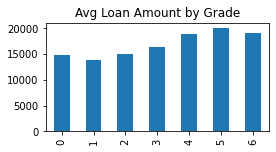

In [84]:
group_by_grade_pd.plot(kind='bar', figsize=(4,2))
plt.title('Avg Loan Amount by Grade')
plt.gca().legend_.remove()
plt.show()
#adjust styling here

In [87]:
#removing from cache
group_by_grade.unpersist()
group_by_subgrade.unpersist()

DataFrame[sub_grade: string, mean(loan_amnt): double, mean(annual_inc): double, sum(is_default): bigint]

Data Quality Checks

In [88]:
#Check dataframe columnns
#df_new.columns

Checking that correct data types were inferred

In [89]:
#The following attributes are strings but they potentially should be numeric. Let's take a look at a sample.
df.select('revol_bal', 'revol_util', 'tax_liens', 'tot_cur_bal', 'int_rate', 'emp_length').show()

+---------+----------+---------+-----------+--------+----------+
|revol_bal|revol_util|tax_liens|tot_cur_bal|int_rate|emp_length|
+---------+----------+---------+-----------+--------+----------+
|     9786|     13.4%|        0|     181540|   9.80%| 10+ years|
|    19339|     42.5%|        0|     430856|   5.32%|    1 year|
|    43413|     51.9%|        0|     193745|  18.49%| 10+ years|
|    21831|     50.3%|        0|     408118|  15.77%|   2 years|
|    12900|    102.4%|        0|     133285|  19.89%|  < 1 year|
|    28475|     51.8%|        0|      42952|  10.78%|   8 years|
|     7179|     39.7%|        0|      10353|  16.59%|   5 years|
|    20862|     54.3%|        0|     305781|   7.49%| 10+ years|
|    31200|       42%|        0|      34856|  13.99%| 10+ years|
|    11008|     41.4%|        0|      31915|  10.78%|   3 years|
|    28705|     56.3%|        0|     265836|  12.88%|    1 year|
|    51507|     64.5%|        0|     221110|   6.49%| 10+ years|
|      732|     31.1%|   

In [90]:
#Removing the % character from revol_util
df = df.withColumn("revol_util", F.expr("substring(revol_util, 1, length(revol_util)-1)"))

In [91]:
#Removing the % character from revol_util
df = df.withColumn("int_rate", F.expr("substring(int_rate, 1, length(revol_util)-1)"))

In [92]:
#Notice that we are not casting emp_length to numeric as the time periods it represents are different - it will have to be one hot encoded
integer = ["revol_bal", "tax_liens", "tot_cur_bal", "funded_amnt"]

In [93]:
for c in integer:
    df = df.withColumn(c, df[c].cast("int"))

In [94]:
#Updating revol_util to double:
df = df.withColumn('revol_util', F.col('revol_util').cast('double'))

In [95]:
#Updating int_rate to double:
df = df.withColumn('int_rate', F.col('int_rate').cast('double'))

In [96]:
for c in integer:
    df = df.withColumn(c, F.col(c).cast('int'))

In [97]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.LC_table')

In [98]:
##Registering the dataframe as a temporary table:
#Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 
#If you want to have a temporary view that is shared among all sessions and keep alive until the Spark application terminates, 
#you can create a global temporary view

df.createOrReplaceTempView("LC_Glob_Temp_View")

In [99]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|         telco_churn|      false|
| default|             cc_data|      false|
| default|            employee|      false|
| default|     winequality_red|      false|
| default|simpsons_spark_table|      false|
| default|         afinn_table|      false|
| default|             circles|      false|
| default|     lc_model_scores|      false|
| default|          pysparktab|      false|
| default|zapatero_churn_pr...|      false|
| default|     telco_churn_cml|      false|
| default|israel_streets_po...|      false|
| default|israel_streets_po...|      false|
| default|       hive_on_hbase|      false|
| default|      hive_on_hbase2|      false|
| default|      hive_on_hbase3|      false|
| default|             ice_cml|      false|
| default|             ice_jan|      false|
| default|              newice|      false|
| default|        hive_ext_new| 

In [100]:
spark.catalog.dropTempView("LC_Glob_Temp_View")

In [101]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|         telco_churn|      false|
| default|             cc_data|      false|
| default|            employee|      false|
| default|     winequality_red|      false|
| default|simpsons_spark_table|      false|
| default|         afinn_table|      false|
| default|             circles|      false|
| default|     lc_model_scores|      false|
| default|          pysparktab|      false|
| default|zapatero_churn_pr...|      false|
| default|     telco_churn_cml|      false|
| default|israel_streets_po...|      false|
| default|israel_streets_po...|      false|
| default|       hive_on_hbase|      false|
| default|      hive_on_hbase2|      false|
| default|      hive_on_hbase3|      false|
| default|             ice_cml|      false|
| default|             ice_jan|      false|
| default|              newice|      false|
| default|        hive_ext_new| 

In [102]:
#spark.catalog.dropGlobalTempView("LC_Loans_2015_GlobalTempView")

In [103]:
spark.sql("SELECT * FROM default.LC_table")

DataFrame[acc_now_delinq: int, acc_open_past_24mths: int, addr_state: string, annual_inc: double, application_type: string, avg_cur_bal: int, chargeoff_within_12_mths: int, collections_12_mths_ex_med: int, delinq_2yrs: int, delinq_amnt: int, dti: double, earliest_cr_line: string, emp_length: string, funded_amnt: int, funded_amnt_inv: double, grade: string, home_ownership: string, initial_list_status: string, inq_last_6mths: int, installment: double, int_rate: double, issue_d: string, loan_amnt: int, loan_status: string, mo_sin_old_rev_tl_op: int, mo_sin_rcnt_rev_tl_op: int, mo_sin_rcnt_tl: int, mort_acc: int, num_accts_ever_120_pd: int, num_actv_bc_tl: int, num_actv_rev_tl: int, num_bc_sats: int, num_bc_tl: int, num_il_tl: int, num_op_rev_tl: int, num_rev_accts: int, num_rev_tl_bal_gt_0: int, num_sats: int, num_tl_30dpd: int, num_tl_90g_dpd_24m: int, num_tl_op_past_12m: int, open_acc: int, pct_tl_nvr_dlq: double, policy_code: int, pub_rec: int, pub_rec_bankruptcies: int, purpose: strin

In [104]:
spark.stop()